In [4]:
import os
import base64
import re
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
OUTPUT_DIR = "emails_md"

def get_email_body(parts):
    if not parts:
        return ""
    
    for part in parts:
        mime_type = part.get("mimeType")
        body = part.get("body")
        data = body.get("data")
        
        if mime_type == "text/plain" and data:
            text = base64.urlsafe_b64decode(data).decode("utf-8")
            return text
        elif mime_type == "multipart/alternative":
            return get_email_body(part.get("parts"))
            
    if parts[0].get("body").get("data"):
         text = base64.urlsafe_b64decode(parts[0].get("body").get("data")).decode("utf-8")
         return text
         
    return ""

def sanitize_filename(filename):
    return re.sub(r'[\\/*?:"<>|]', "", filename)

def main():
    creds = None
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.json', 'w') as token:
            token.write(creds.to_json())

    try:
        service = build('gmail', 'v1', credentials=creds)

        if not os.path.exists(OUTPUT_DIR):
            os.makedirs(OUTPUT_DIR)
            print(f"Directory '{OUTPUT_DIR}' created.")

        print("Fetching the list of the last 100 emails...")
        results = service.users().messages().list(userId='me', maxResults=100).execute()
        messages = results.get('messages', [])

        if not messages:
            print("No emails found.")
            return

        print(f"{len(messages)} emails found. Processing and saving...")

        for i, message_info in enumerate(messages):
            msg_id = message_info['id']
            msg = service.users().messages().get(userId='me', id=msg_id, format='full').execute()
            
            payload = msg.get('payload')
            headers = payload.get('headers')
            
            subject = next((header['value'] for header in headers if header['name'].lower() == 'subject'), 'No Subject')
            sender = next((header['value'] for header in headers if header['name'].lower() == 'from'), 'No Sender')
            date = next((header['value'] for header in headers if header['name'].lower() == 'date'), 'No Date')

            parts = payload.get('parts')
            body = get_email_body(parts)

            md_content = f"""# {subject}

**From:** {sender}
**Date:** {date}
**ID:** {msg_id}

---

{body.strip()}
"""
            
            filename = f"{msg_id}.md"
            filepath = os.path.join(OUTPUT_DIR, filename)
            
            with open(filepath, 'w', encoding='utf-8') as f:
                f.write(md_content)
            
            print(f"Email {i+1}/{len(messages)} saved to '{filepath}'.")

        print(f"\n✅ Operation completed successfully!")
        print(f"{len(messages)} emails have been saved in the '{OUTPUT_DIR}' directory.")

    except HttpError as error:
        print(f'An error occurred: {error}')
    except Exception as e:
        print(f'An unexpected error occurred: {e}')

if __name__ == '__main__':
    main()

Directory 'emails_md' created.
Fetching the list of the last 100 emails...
100 emails found. Processing and saving...
Email 1/100 saved to 'emails_md\1984fef5e7c33bfb.md'.
Email 2/100 saved to 'emails_md\1984f8174c0a12f1.md'.
Email 3/100 saved to 'emails_md\1984e4160150d66b.md'.
Email 4/100 saved to 'emails_md\1984ba4b09a0aed8.md'.
Email 5/100 saved to 'emails_md\1984b829e3c78400.md'.
Email 6/100 saved to 'emails_md\1984b81cf6f3b09c.md'.
Email 7/100 saved to 'emails_md\1984b36cac6a2f84.md'.
Email 8/100 saved to 'emails_md\1984b27aba9031fb.md'.
Email 9/100 saved to 'emails_md\1984ac9575b962df.md'.
Email 10/100 saved to 'emails_md\1984a5b1c9fe25d6.md'.
Email 11/100 saved to 'emails_md\198467e7b869f5f4.md'.
Email 12/100 saved to 'emails_md\1984610b7c4e56b2.md'.
Email 13/100 saved to 'emails_md\19845fdd0d743562.md'.
Email 14/100 saved to 'emails_md\19845a3044ac32ef.md'.
Email 15/100 saved to 'emails_md\1984534cf99dc492.md'.
Email 16/100 saved to 'emails_md\19844b31d9f4bae3.md'.
Email 17/10

In [23]:
import os 
import glob
from langchain_chroma import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.schema import document
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI , OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.document_loaders import DirectoryLoader, TextLoader
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [10]:
MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [26]:
Api_key='***********************'

In [54]:
folder =glob.glob('emails_md')
text_kargs={'encoding':'utf-8'}
documents=[]
loader=DirectoryLoader(folder[0],glob='*.md',loader_cls=TextLoader,loader_kwargs=text_kargs)
file_doc=loader.load()
for doc in file_doc:
    documents.append(doc)

In [59]:
text_spliter=RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
chunks=text_spliter.split_documents(documents)

In [60]:
embedings=OpenAIEmbeddings(base_url='https://api.gapgpt.app/v1',api_key=Api_key)
if os.path.exists(db_name):
    Chroma(persist_directory=db_name,embedding_function=embedings).delete_collection()
vectorestore=Chroma.from_documents(documents=chunks, persist_directory=db_name,embedding=embedings)

In [33]:
collection=vectorestore._collection
reslut=collection.get(include=['embeddings','documents'])
vector=np.array(reslut['embeddings'])
documents=reslut['documents']

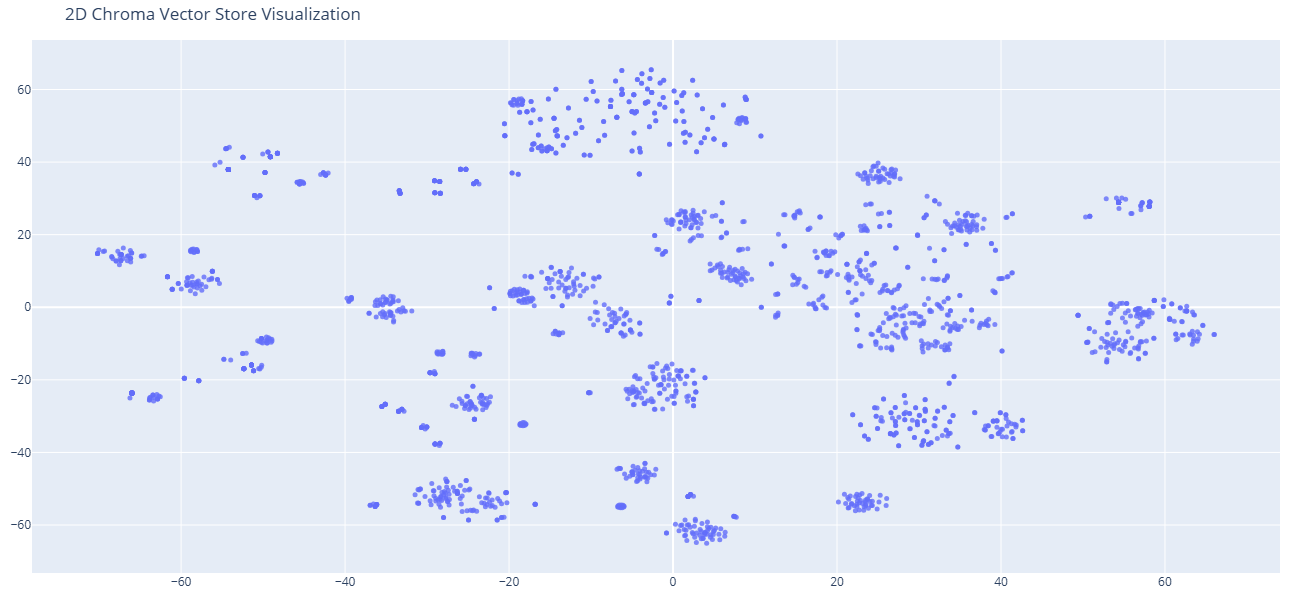

In [36]:
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vector)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, opacity=0.8),
  
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

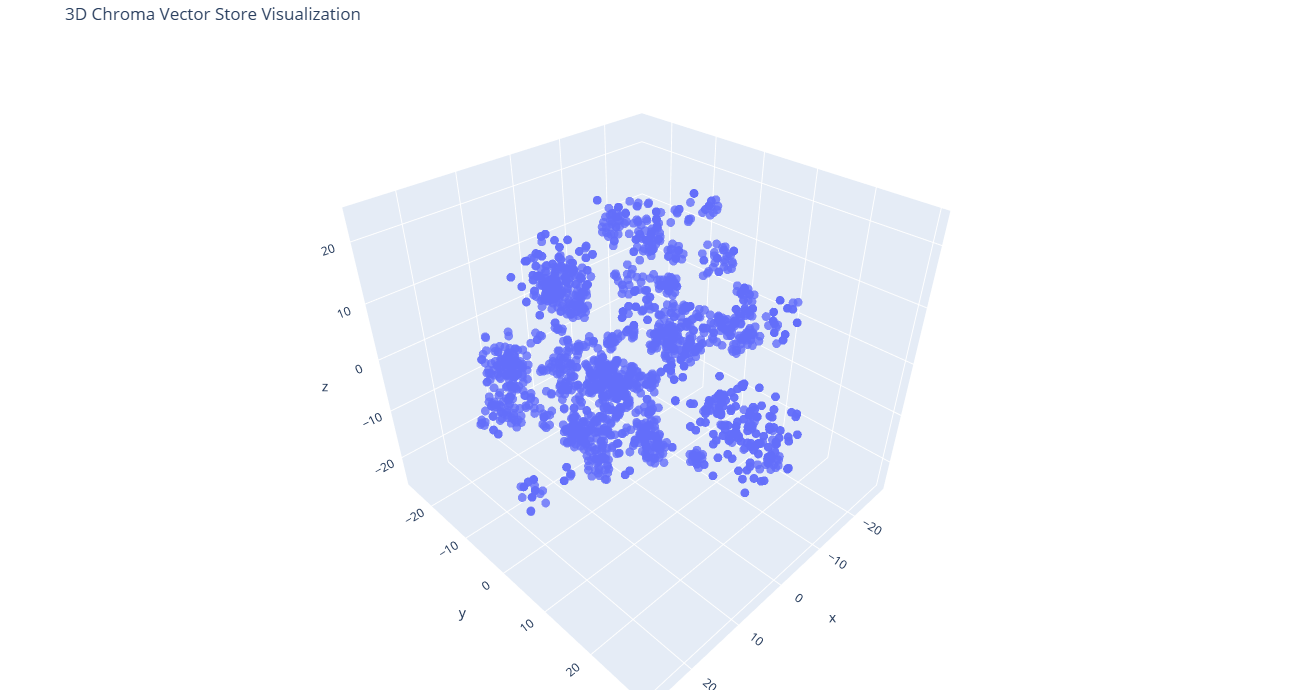

In [38]:
tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vector)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, opacity=0.8),
  
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [49]:

llm=ChatOpenAI(base_url='https://api.gapgpt.app/v1',api_key=Api_key,model=MODEL)

memory=ConversationBufferMemory(memory_key='chat_history',return_messages=True)

retriever=vectorestore.as_retriever()
conversation_chain=ConversationalRetrievalChain.from_llm(llm=llm,retriever=retriever,memory=memory)

In [50]:
def chat(message,history):
    result=conversation_chain.invoke({'question':message})
    return result['answer']

In [51]:
import gradio as gr
gr.ChatInterface(fn=chat,type='messages').launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.
